# PyTorch Model on Real Dataset (v8)

#### Chess Board Object Detection

#### CIS 520, Spring 2019

This notebook is written to run on [Google Colab](https://colab.research.google.com/notebook). Would not recommend running it locally because it downloads multiple GBs of data and runs computationally expensive tasks. (although it should work once you install required packages).

Colab comes with all of the necessary packages preinstalled and gives free GPU access.

## Instructions
* Go to Runtime > Change runtime Type and set it to GPU
* Run all cells
* Some cells will take a few minutes to run:
    - Git imports should take ~5 minutes
    - Preprocessing should take ~15 minutes
    - Actual training time should be less than 20 seconds per epoch
* There is one cell where we import ngrok to open a tensorboard window, sometimes this cell produces a weird error. If this occurs just run it again and it should work.

----


In [0]:
# # Check out available CPU and GPU memory
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU

def print_CPU_GPU_info(GPUs):
    ''' Prints out CPU and GPU memory utilization (useful in Google Colab) '''
    process = psutil.Process(os.getpid())
    print(f"\nCPU \tRAM Free: {humanize.naturalsize(psutil.virtual_memory().available)}"
          f"    | Proc size: {humanize.naturalsize(process.memory_info().rss)}")
    if GPUs[0]: 
        for i,gpu in enumerate(GPUs):
            print(f"GPU {i} \tRAM Free: {gpu.memoryFree/1000:.3f} GB  "
                  f"| Used: {gpu.memoryUsed/1000:.3f} GB"
                  f"\t| Utilization: {gpu.memoryUtil*100:3.0f}% | "
                  f"Total Memory: {gpu.memoryTotal/1000:.3f} GB")
    else: print(f"Not on a GPU")


  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil


In [0]:
print_CPU_GPU_info(GPU.getGPUs())


CPU 	RAM Free: 12.8 GB    | Proc size: 120.1 MB
GPU 0 	RAM Free: 15.079 GB  | Used: 0.000 GB	| Utilization:   0% | Total Memory: 15.079 GB


In [0]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) { return false; }
// disable scrollable cells

<IPython.core.display.Javascript object>

# Pull code and data from GitHub

In [0]:
! git clone https://github.com/samryan18/chess-ray-vision
! mv chess-ray-vision/src/* .
! mv chess-ray-vision/assets/* .
! pip install -e chess-ray-vision

#NOTE this next line will download 2+ GB of data
#Do not run locally unless your comp can take that kinda heat
! git clone https://github.com/mukundv7/crvdataset 
! mkdir train_full
! mv crvdataset/chess-positions/train-full/* train_full/
! mv crvdataset/golden_dataset golden_dataset

Cloning into 'chess-ray-vision'...
remote: Enumerating objects: 100, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 377 (delta 42), reused 76 (delta 21), pack-reused 277
Receiving objects: 100% (377/377), 117.39 MiB | 44.70 MiB/s, done.
Resolving deltas: 100% (148/148), done.
Obtaining file:///content/chess-ray-vision
    100% |████████████████████████████████| 25.4MB 1.4MB/s 
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
  Found existing installation: opencv-python 3.4.5.20
    Uninstalling opencv-python-3.4.5.20:
      Successfully uninstalled opencv-python-3.4.5.20
  Running setup.py develop for preprocessing
Cloning into 'crvdataset'...
remote: Enumerating objects: 40522, done.
remote: Total 40522 (delta 0), reused 0 (delta 0), pack-reused 40522
Receiving objects: 100% (40522/40522), 2.89 GiB | 41.07 MiB/s, done.
Resolving deltas: 100% (282/282), d

In [0]:
# If you want to preprocess in colab do something like this
# ! mkdir golden_dataset/labeled_preprocessed
# ! preprocess --verbose --glob_path="golden_dataset/good_ass_labels/*.*" --dest_path="golden_dataset/labeled_preprocessed"



In [0]:
# if necessary
import os
def rename_delims(directory: str, 
                  current_delimiter: str=':', 
                  update_delimiter: str="-"):
    '''
    Changes FEN delimiter in filenames.
    
    Some fens are 8-8-8...
    But sometimes for some reason we might want to switch it to 8:8:8...
    This allows us to rename all the files in a directory 
    '''
    for fname in os.listdir(directory):
        src =f'{directory}/{fname}'
        dest = src.replace(current_delimiter,update_delimiter)
        os.rename(src, dest) 

# Setup Stuff

In [0]:
# Pytorch Colab Setup
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'
!pip3 install https://download.pytorch.org/whl/cu100/torch-1.0.1-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision
  
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Running on: {device}')

    100% |████████████████████████████████| 614.8MB 26kB/s 
  Found existing installation: torch 1.0.1.post2
    Uninstalling torch-1.0.1.post2:
      Successfully uninstalled torch-1.0.1.post2
Running on: cuda:0


In [0]:
%matplotlib inline

'''
other imports are scattered through the notebook 
near the functions they're used in

sorry.. **shrug**
'''

####################################################
# CODE IMPORTS

from pytorch_general.pytorch_helper import imshow
from pytorch_general.tensorboard_helper import Logger
from utils.data_loading_utils import (onehot_from_fen, fen_from_onehot, 
                                     fen_from_64, fen_from_filename, 
                                     process_image)
from utils.draw_chess_boards import DrawChessPosition

####################################################
# EXTERNAL IMPORTS

import torchvision
import torch 
import torch.nn as nn
import torchvision.datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import numpy as np;
from torch.utils.data import Dataset, DataLoader
import time, datetime
from tqdm import tqdm
from torchsummary import summary

from random import randint

from PIL import Image
from pathlib import Path
from random import shuffle
import os


import glob

import torch.optim as optim
device =torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [0]:
# test one hot to/from fen functionality
fen = '4kN1N-bbbbbbbb-QQ3B2-R1n1b3-8-8-ppqKbKbk-8'
class_prob = onehot_from_fen(fen)

print(f"""
Testing one_hot_from_fen function:
Original: \t{fen}
Reconstructed:  {fen_from_onehot(class_prob)}
""")


Testing one_hot_from_fen function:
Original: 	4kN1N-bbbbbbbb-QQ3B2-R1n1b3-8-8-ppqKbKbk-8
Reconstructed:  4kN1N-bbbbbbbb-QQ3B2-R1n1b3-8-8-ppqKbKbk-8



# Dataloader

In [83]:
# This cell will take ~15 mintues to run

from skimage.util.shape import view_as_blocks
from skimage import transform as sktransform
from skimage import io

def process_image(img, downsample_size = 200):
    square_size = int(downsample_size/8)

    img = sktransform.resize(io.imread(img), 
                                  (downsample_size, downsample_size), 
                                  mode='constant',
                                  anti_aliasing=True)
    tiles = view_as_blocks(img[:,:,0:3], 
                           block_shape=(square_size, square_size, 3))
    return tiles.reshape(64, square_size, square_size, 3), img


from torch.utils.data.sampler import SubsetRandomSampler
def make_samplers(dataset, 
                  validation_split=0.1, 
                  shuffle_dataset = True,
                  random_seed= 42):
    ''' Makes samplers to split train and test data '''
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split = int(np.floor(validation_split * dataset_size))
    if shuffle_dataset :
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    train_indices, val_indices = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)
    return train_sampler, val_sampler


import os
import re
class CustomChessDataset(Dataset):
    """Chess dataset"""

    def __init__(self, 
                 transform=None,
                 root='train_full',
                 dataset_size = None,
                 downsample_size = 200):

        self.downsample_size = downsample_size
            
        self.root = root
        self.pathlist = list(Path(self.root).glob('**/*.*'))
        self.n_files = len(self.pathlist)
        
        self._data = glob.glob(f"{root}/*.*")
        
        if dataset_size == None:
            dataset_size = len(os.listdir(root))

        self.dataset_size = dataset_size
        shuffle(self._data)

        self._data = self._data[:self.dataset_size]

        # to speed up training loop preprocess all data early and cache results
        # 130x speedup!
        with tqdm(total=self.dataset_size, 
                  desc=f'Preprocessing Images: ', 
                  unit=' images') as pbar:
            for idx in tqdm(range(self.dataset_size)):
                img = self._data[idx]
                img_label = re.sub(r'[\_][0-9]+', '',img) # remove underscores for dups
                try:
                    label = onehot_from_fen(fen_from_filename(img_label))
                except:
                    print(img)
                    raise

                img_as_img, original_img = process_image(img, 
                                                         downsample_size = self.downsample_size)
                self._data[idx] = (img_as_img, label, original_img)
                pbar.update(1)

    def __len__(self):
        return self.dataset_size
    
    def __getitem__(self, idx):
        img_as_img, label, original_img = self._data[idx]
        return ((torch.from_numpy(img_as_img).float()), 
                label,
                original_img)

# BATCH_SIZE needs to be small ish bc bigger models will scale 
# memory usage exponentially
BATCH_SIZE=10
downsample_size=200
transform = transforms.Compose([transforms.Resize(downsample_size)])

# train_full/
dataset = CustomChessDataset(root='golden_dataset/labeled_preprocessed', 
                                   downsample_size=downsample_size) 

train_sampler, val_sampler = make_samplers(dataset, 
                                          validation_split=0.1, 
                                          shuffle_dataset = True)

train_loader = torch.utils.data.DataLoader(dataset=dataset,
                                           batch_size=BATCH_SIZE,
                                           sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=BATCH_SIZE,
                                          sampler=val_sampler)  

print(f'Train loader contains {len(train_loader)} batches of size {BATCH_SIZE}')
print(f'Test loader contains {len(test_loader)} batches of size {BATCH_SIZE}')

100%|██████████| 500/500 [14:51<00:00,  1.73s/it]


Train loader contains 45 batches of size 10
Test loader contains 5 batches of size 10


# Training Function

In [0]:
from typing import Tuple

def train_model(model: nn.Module, 
                log_dir: str,
                train_loader: torch.utils.data.DataLoader,
                criterion: torch.nn.modules.Module,
                optimizer: torch.optim.Optimizer,
                num_epochs: int=1,
                log_freq: int=5,
                print_guess=False,
                print_guess_freq=50,
                test_model_after_each_epoch=False,
                test_loader: torch.utils.data.DataLoader=None,
                suppress_output: bool=True,
            ) -> Tuple[nn.Module, str]:
    
    # Create Logging Directory for Tensorboard
    now = time.mktime(datetime.datetime.now().timetuple()) - 1550000000
    log_dir = f'{log_dir} ({now})/'
    logger = Logger(log_dir)
    print(f'Training model. Logging to: "{log_dir}"\n')

    model = model.to(device) # Send model to GPU if possible
    model.train() # Set model to training mode
    
    # for drawing predictions to images
    renderer = DrawChessPosition(delimiter='-')

    total_step = len(train_loader)
    for epoch in range(num_epochs):
        if print_guess: print(f'Epoch {epoch+1}')
        running_loss = 0
        
        # Tqdm will create a progress bar
        with tqdm(total=len(train_loader), 
                  desc=f'Epoch {epoch+1}', 
                  unit=' minibatches',
                  disable=(print_guess)) as pbar:
            
            # Iterate through minibatches
            for step, (images, labels, original_imgs) in enumerate(train_loader):
                images, labels = images.to(device), labels.long().to(device)

                output = model(images).to(device)
                _,class_labels = torch.max(labels,2) 
                _, argmax = torch.max(output, 2)

                accuracy = float((class_labels == 
                                  argmax.squeeze()).float().mean().cpu())

                loss = criterion(output.reshape(10*64,13).float(),
                                 class_labels.reshape(10*64))

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()


                running_loss += float(loss.item())

                pbar.set_postfix(training_accuracy=accuracy, loss=loss.item(), refresh=True)
                pbar.update(1)

                if step % log_freq == 0:
                    overall_step = epoch*total_step + step
                    
                    info = { 'loss': loss.item(), 'accuracy': accuracy }

                    for key, value in info.items():
                        logger.scalar_summary(key, value, overall_step)
                    

                    info = { f'{fen_from_64(argmax.cpu()[0])}': 
                                    [original_imgs[0].cpu()]}

                    for tag, images in info.items():
                        logger.image_summary(tag, images, overall_step)

                    for key, value in model.named_parameters():
                        key = key.replace('.', '/')
                        logger.histo_summary(key, 
                                             value.data.cpu().numpy(), 
                                             overall_step)
                        try:
                            logger.histo_summary(key+'/grad', 
                                                 value.grad.data.cpu().numpy(),
                                                 overall_step)
                        except (AttributeError):
                            # During transfer learning some of the variables 
                            # don't have grads
                            pass

                if print_guess and step % print_guess_freq == 0:
                    overall_step = epoch*total_step + step
                    print(f"\n{60*'-'}\nBatch Number: {overall_step}")
                    print(f"Example training point:")
                    print(f"Actual: {fen_from_64(class_labels.cpu()[0])}")
                    print(f"Guess: {fen_from_64(argmax.cpu()[0])}")
                    print(f"Example Accuracy: {float((class_labels[0] == argmax[0]).float().mean().cpu())}")

                    board_actual = renderer.draw(fen_from_64(class_labels.cpu()[0]))
                    board_guess = renderer.draw(fen_from_64(argmax.cpu()[0]))
                    renderer.show_side_by_side(board1= original_imgs[0],
                                               board2=board_guess, 
                                               board1_title='Actual',
                                               board2_title='Prediction (Re'
                                                            'ndered to image)')
        
        if not suppress_output:   
            print(f"{epoch}: Training loss: {running_loss/len(train_loader)}")
            print(f"{epoch}: Training accuracy: {accuracy}")
        
        if test_model_after_each_epoch:
            if test_loader:
                epoch_val_acc = test_model(model, test_loader, criterion, print_guess=False)
                info = { 'validation_accuracy': epoch_val_acc }

                for key, value in info.items():
                    logger.scalar_summary(key, value, overall_step)
            else:
                raise Exception('Need to to provide a test loader.')
                return

 
    return (model, log_dir)

def test_model(model: nn.Module, 
                test_loader: torch.utils.data.DataLoader,
                criterion: torch.nn.modules.Module,
                print_guess: bool=False,
                print_guess_freq: int=50,
                suppress_output: bool=True) -> float:
    
    model = model.to(device)
    accuracies = []
    losses = []
    total_step = len(test_loader)
        
    # for drawing predictions to images
    renderer = DrawChessPosition(delimiter='-')
    with torch.no_grad():
        # Tqdm will create a progress bar
        with tqdm(total=len(test_loader), 
                desc=f'Test Batches', 
                unit=' minibatches',
                disable=(print_guess)) as pbar:

            # Iterate through minibatches
            for step, (images, labels, original_imgs) in enumerate(test_loader):
                images, labels = images.to(device), labels.long().to(device)

                output = model(images).to(device)
                _,class_labels = torch.max(labels,2) 
                _, argmax = torch.max(output, 2)

                accuracy = float((class_labels == 
                                argmax.squeeze()).float().mean().cpu())

                loss = criterion(output.reshape(10*64,13).float(),
                                class_labels.reshape(10*64))
                losses.append(float(loss.item()))
                accuracies.append(accuracy)

                pbar.set_postfix(test_acc=accuracy, test_loss=loss.item(), refresh=True)
                pbar.update(1)

                if print_guess and step % print_guess_freq == 0:

                    overall_step = total_step + step
                    print(f"\n{60*'-'}\nTest Batch Number: {overall_step}")
                    print(f"Example testing point:")
                    print(f"Actual: {fen_from_64(class_labels.cpu()[0])}")
                    print(f"Guess: {fen_from_64(argmax.cpu()[0])}")
                    print(f"Example Accuracy: {float((class_labels[0] == argmax[0]).float().mean().cpu())}")

                    board_actual = renderer.draw(fen_from_64(class_labels.cpu()[0]))
                    board_guess = renderer.draw(fen_from_64(argmax.cpu()[0]))
                    renderer.show_side_by_side(board1= original_imgs[0],
                                            board2=board_guess, 
                                            board1_title='Actual',
                                            board2_title='Prediction (Re'
                                                            'ndered to image)')

    if not suppress_output:                   
        print(f'\nAvg. Accuracy of the network on test images: {np.average(accuracies)}')
        print(f'Avg. Loss of the network on test images: {np.average(losses)}')

    return np.average(accuracies)

def view_classify(model: nn.Module, 
                data_loader: torch.utils.data.DataLoader,
                num_view: int=2):
    
    model = model.to(device)
    total_step = len(data_loader)
        
    # for drawing predictions to images
    renderer = DrawChessPosition(delimiter='-')
    num_seen = 0
    with torch.no_grad():

        # Iterate through minibatches
        for step, (images, labels, original_imgs) in enumerate(data_loader):
            images, labels = images.to(device), labels.long().to(device)

            output = model(images).to(device)
            _,class_labels = torch.max(labels,2) 
            _, argmax = torch.max(output, 2)


            for i in range(len(class_labels.cpu())):
                print(f"Example image point:")
                print(f"Actual: {fen_from_64(class_labels.cpu()[i])}")
                print(f"Guess: {fen_from_64(argmax.cpu()[i])}")
                print(f"Example Accuracy: {float((class_labels[i] == argmax[i]).float().mean().cpu())}")

                board_actual = renderer.draw(fen_from_64(class_labels.cpu()[i]))
                board_guess = renderer.draw(fen_from_64(argmax.cpu()[i]))
                renderer.show_side_by_side(board1= original_imgs[i],
                                        board2=board_guess, 
                                        board1_title='Example Actual '
                                                     'Validation Image',
                                        board2_title='Prediction (Re'
                                                     'ndered to image)')
                num_seen+=1
                if num_seen >= num_view:
                    break
            if num_seen >= num_view:
                    break

# Models

In [0]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1) 

class SimpleCNN(torch.nn.Module):
    def __init__(self, batch_size):
        super(SimpleCNN, self).__init__()
        self.name = 'SimpleCNN'
        self.batch_size=batch_size
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1),
            nn.LeakyReLU(negative_slope=0.1))
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1),
            nn.ReLU())
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1),
            nn.ReLU())
        self.flatten = Flatten()
        self.fc1 = nn.Sequential(
            nn.Linear(32*19*19, 256),
            nn.ReLU(),
            nn.Dropout(p = 0.1))
        self.fc2 = nn.Sequential(
            nn.Linear(256, 13))

    def forward(self, x):
        x = x.reshape(self.batch_size*64,3,25,25)

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        x = self.flatten(x)
        
        x = self.fc1(x)
        x = self.fc2(x)
#         print(f'xsize: {x.size()}')
        x = x.reshape(self.batch_size,64,13)

        return(x)
    
class BiggerCNN(torch.nn.Module):
    def __init__(self, batch_size):
        super(BiggerCNN, self).__init__()
        self.name = 'BiggerCNN'
        self.batch_size=batch_size
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1),
            nn.LeakyReLU(negative_slope=0.1))
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU())
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU())
        self.flatten = Flatten()
        self.fc1 = nn.Sequential(
            nn.Linear(64*19*19, 512),
            nn.ReLU(),
            nn.Dropout(p = 0.1))
        self.fc2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(p = 0.1))
        self.fc3 = nn.Sequential(
            nn.Linear(256, 13))

    def forward(self, x):
        x = x.reshape(self.batch_size*64,3,25,25)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        x = self.flatten(x)
        
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)

#         print(f'xsize: {x.size()}')
        x = x.reshape(self.batch_size,64,13)

        return(x)
    
class BiggerCNN_No_Dropout(torch.nn.Module):
    def __init__(self, batch_size):
        super(BiggerCNN_No_Dropout, self).__init__()
        self.name = 'BiggerCNN_No_Dropout'
        self.batch_size=batch_size
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1),
            nn.LeakyReLU(negative_slope=0.1))
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU())
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU())
        self.flatten = Flatten()
        self.fc1 = nn.Sequential(
            nn.Linear(64*19*19, 512),
            nn.ReLU())
        self.fc2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU())
        self.fc3 = nn.Sequential(
            nn.Linear(256, 13))

    def forward(self, x):
#         print(x.size())
        x = x.reshape(self.batch_size*64,3,25,25)

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        x = self.flatten(x)
        
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
#         print(x.size())
#         print(f'xsize: {x.size()}')
        x = x.reshape(self.batch_size,64,13)

        return(x)
    
    
# class MoreSkinnierLayersBiggerCNN(torch.nn.Module):
#     def __init__(self, batch_size):
#         super(MoreSkinnierLayersBiggerCNN, self).__init__()
#         self.name = 'MoreSkinnierLayersBiggerCNN'
#         self.batch_size=batch_size
#         self.conv1 = nn.Sequential(
#             nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1),
#             nn.LeakyReLU(negative_slope=0.1))
#         self.conv2 = nn.Sequential(
#             nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, stride=1),
#             nn.ReLU())
#         self.conv3 = nn.Sequential(
#             nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1),
#             nn.ReLU())
#         self.conv4 = nn.Sequential(
#             nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1),
#             nn.ReLU())
#         self.conv5 = nn.Sequential(
#             nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1),
#             nn.ReLU())
#         self.flatten = Flatten()
#         self.fc1 = nn.Sequential(
#             nn.Linear(640*2704, 512),
#             nn.ReLU(),
#             nn.Dropout(p = 0.1))
#         self.fc2 = nn.Sequential(
#             nn.Linear(512, 256),
#             nn.ReLU(),
#             nn.Dropout(p = 0.1))
#         self.fc3 = nn.Sequential(
#             nn.Linear(256, 13))

#     def forward(self, x):
#         x = x.reshape(self.batch_size*64,3,25,25)

#         x = self.conv1(x)
#         x = self.conv2(x)
#         x = self.conv3(x)
#         x = self.conv3(x)
#         x = self.conv4(x)
#         x = self.conv5(x)
        
#         x = self.flatten(x)
        
#         x = self.fc1(x)
#         x = self.fc2(x)
#         x = self.fc3(x)

# #         print(f'xsize: {x.size()}')
#         x = x.reshape(self.batch_size,64,13)

#         return(x)

    
# class BatchNormBiggerCNN(torch.nn.Module):
#     def __init__(self, batch_size):
#         super(BatchNormBiggerCNN, self).__init__()
#         self.name = 'BatchNormBiggerCNN'
#         self.batch_size=batch_size
#         self.conv1 = nn.Sequential(
#             nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1),
#             nn.BatchNorm2d(64),
#             nn.LeakyReLU(negative_slope=0.1),
#             nn.Dropout(p = 0.1))
#         self.conv2 = nn.Sequential(
#             nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(),
#             nn.Dropout(p = 0.1))
#         self.conv3 = nn.Sequential(
#             nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
#             nn.ReLU())
#         self.flatten = Flatten()
#         self.fc1 = nn.Sequential(
#             nn.Linear(64*19*19, 512),
#             nn.ReLU(),
#             nn.Dropout(p = 0.1))
#         self.fc2 = nn.Sequential(
#             nn.Linear(512, 256),
#             nn.ReLU(),
#             nn.Dropout(p = 0.1))
#         self.fc3 = nn.Sequential(
#             nn.Linear(256, 13))

#     def forward(self, x):
#         x = x.reshape(self.batch_size*64,3,25,25)

#         x = self.conv1(x)
#         x = self.conv2(x)
#         x = self.conv3(x)
        
#         x = self.flatten(x)
        
#         x = self.fc1(x)
#         x = self.fc2(x)
#         x = self.fc3(x)

# #         print(f'xsize: {x.size()}')
#         x = x.reshape(self.batch_size,64,13)

#         return(x)

In [0]:
import numpy as np
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

import matplotlib as mpl
import matplotlib.pyplot as plt

def load_tf_log(path):
    tf_size_guidance = { 
        'compressedHistograms': 10, 'histograms': 1, 'images': 0, 
        'scalars': 40000000, }

    event_acc = EventAccumulator(path, tf_size_guidance)
    event_acc.Reload()
    
#     print(event_acc.Tags()['scalars']) # Show all tags in the log file
#     scalars = event_acc.Tags()['scalars']
#     for scalar in scalars:
#         data = event_acc.Scalars(scalar)
    accuracies = event_acc.Scalars('accuracy')
    losses = event_acc.Scalars('loss')
    validation_accuracies = event_acc.Scalars('validation_accuracy')
    return accuracies, losses, validation_accuracies

def plot_tensorflow_log(path, title='', figsize=(7,4)):
    # Loading too much data is slow... (but fuck it)
    accuracies, losses, validation_accuracies = load_tf_log(path)

    steps = len(accuracies)
    x = np.arange(steps)
    
    y = np.zeros([steps, 2])
#     print(accuracies[1][1])

    for i in range(steps):
        x[i] = accuracies[i][1]
        y[i, 0] = accuracies[i][2] # value
        y[i, 1] = losses[i][2]
    
    
    val_steps = len(validation_accuracies)
    x_val = np.arange(val_steps)
    y_val = np.zeros(val_steps)
    for i in range(val_steps):
        x_val[i] = validation_accuracies[i][1]
        y_val[i] = validation_accuracies[i][2] # value
        

    
    f, axarr = plt.subplots(1,2, figsize=(2*figsize[0],figsize[1]))
        
    axarr[0].plot(x, y[:,0], label='training accuracy')
    axarr[0].plot(x_val, y_val, label='validation accuracy')
    axarr[0].set_title('Accuracy Over Training')
    axarr[0].set_ylabel("Accuracy")
    axarr[1].plot(x, y[:,1], label='loss')
    axarr[1].set_title('Loss Over Training')
    axarr[1].set_ylabel("Loss")
    for ax in axarr:
        ax.set_xlabel("Mini-batches (10 images per batch)")
        ax.grid()
        ax.legend(frameon=True)
        
    plt.show()

In [0]:
rm -rf logs

# Train the Models

In [0]:
# input size: torch.Size([10, 64, 25, 25, 3])
# output size: torch.Size([640, 13])

class BetterNet(torch.nn.Module):
    def __init__(self, batch_size):
        super(BetterNet, self).__init__()
        self.name = 'BetterNet'
        self.batch_size=batch_size
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Dropout(p = 0.1))
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Dropout(p = 0.1))
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=3, padding=0))
        self.flatten = Flatten()
        self.fc1 = nn.Sequential(
            nn.Linear(1152, 512),
            nn.ReLU())
        self.fc2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(p = 0.1))
        self.fc3 = nn.Sequential(
            nn.Linear(256, 13))

    def forward(self, x):
        x = x.reshape(self.batch_size*64,3,25,25)

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        
        x = self.flatten(x)
#         x = x.view(-1,640*117)
#         print(x.size()[1])
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)

#         print(f'xsize: {x.size()}')
        x = x.reshape(self.batch_size,64,13)

        return(x)
    

In [120]:
from google.colab import drive
drive.mount('/content/gdrive')

def save_model_to_drive(model, model_save_name = 'classifier.pt'):
    
    path = F"/content/gdrive/My Drive/{model_save_name}" 
    torch.save(model.state_dict(), path)

def load_model_from_drive(model, model_save_name = 'classifier.pt'):
    model_save_name = 'classifier.pt'
    path = F"/content/gdrive/My Drive/{model_save_name}"
    model.load_state_dict(torch.load(path))
    return model

            


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [121]:
# Sometimes this cell gives a weird error
# Just rerun it until it works

LOG_DIR = './logs'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

!if [ -f ngrok ] ; then echo "Ngrok already installed" ; else wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip > /dev/null 2>&1 && unzip ngrok-stable-linux-amd64.zip > /dev/null 2>&1 ; fi

get_ipython().system_raw('./ngrok http 6006 &')

! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print('Tensorboard Link: ' +str(json.load(sys.stdin)['tunnels'][0]['public_url']))"

Ngrok already installed
Tensorboard Link: https://5d8ffaf9.ngrok.io


Epoch 1:   2%|▏         | 1/45 [00:00<00:05,  8.07 minibatches/s, loss=2.55, training_accuracy=0.0609]

Training: BiggerCNN_No_Dropout
Learning Rate: 0.0005
Training model. Logging to: "./logs/BiggerCNN_No_Dropout_lr0.0005 (6049183.0)/"



Test Batches: 100%|██████████| 5/5 [00:00<00:00, 28.21 minibatches/s, test_acc=0.952, test_loss=0.294]


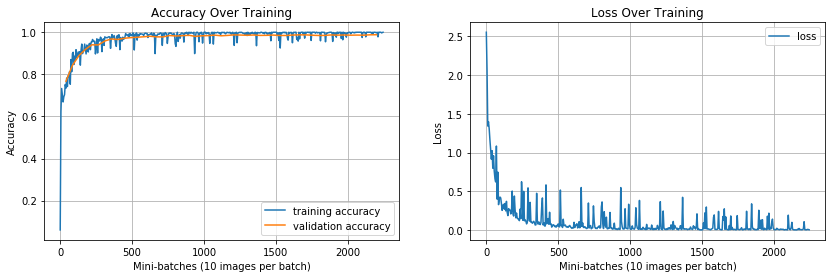

Example image point:
Actual: 5k2-1R6-8-1p4P1-8-5q2-1PP5-1K2R3
Guess: 5k2-1R6-8-1p4P1-8-5q2-1PP5-1K2R3
Example Accuracy: 1.0


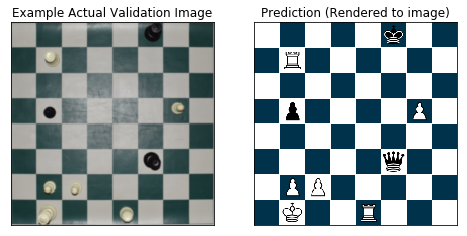

Example image point:
Actual: 4Bk2-r7-3q1N2-2Q5-3r1P2-6P1-PP3P2-6K1
Guess: 4Bk2-r7-3q1N2-2Q5-3r1P2-6P1-PP3P2-6K1
Example Accuracy: 1.0


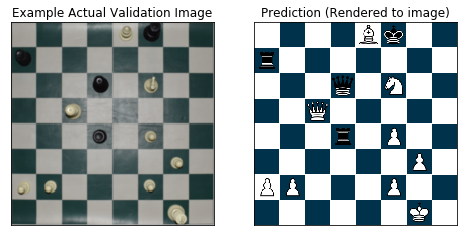

Epoch 1:   2%|▏         | 1/45 [00:00<00:05,  8.17 minibatches/s, loss=2.55, training_accuracy=0.0156]

Training: BiggerCNN_No_Dropout
Learning Rate: 0.001
Training model. Logging to: "./logs/BiggerCNN_No_Dropout_lr0.001 (6049631.0)/"



Epoch 25:  47%|████▋     | 21/45 [00:03<00:04,  5.06 minibatches/s, loss=0.00783, training_accuracy=1]

In [0]:
np.warnings.filterwarnings('ignore') # they were getting annoying...

num_epochs = 50
log_freq=5
# learning_rate = .001

log_dirs = []
# BiggerCNN much better for now
# learning_rate = 0.0003
# BiggerCNN_No_Dropout, .0005 seems to be best so far 
# BiggerCNN_No_Dropout best STILL TRUE 4/23
# 4/23 not sure on LR
for cnn in [BiggerCNN_No_Dropout, BiggerCNN, BetterNet]:
    for learning_rate in [.0005, .001, .01]:
    
        net = cnn(batch_size=BATCH_SIZE)
        print(f'Training: {net.name}\nLearning Rate: {learning_rate}')

        optimizer = optim.Adam(net.parameters(), lr=learning_rate)

        log_dir = f'./logs/{net.name}_lr{learning_rate}'
        criterion = nn.CrossEntropyLoss().to(device)

        # print a summary of the net statistics
        #         summary(net.to(device), (BATCH_SIZE*32, 3, 25, 25))

        #     images, labels, original_imgs = next(iter(train_loader))
        #     y = net.to(device)(Variable(images.to(device)))
        #     make_dot(y)

        # Run the model

        model, log_dir = train_model(net,
                        log_dir,
                        train_loader,
                        criterion,
                        optimizer,
                        num_epochs, 
                        log_freq,
                        print_guess_freq=5,
                        print_guess=False,
                        test_model_after_each_epoch=True,
                        test_loader=test_loader) # or print_guess=False for tqdm
        save_model_to_drive(model, f'model_{model.name}_{learning_rate}.pt')
        plot_tensorflow_log(log_dir)
        log_dirs.append(log_dir)
        view_classify(model, test_loader, num_view =2)
        del(model) # just in case :/
        del(criterion)
        del(optimizer)